# Capstone Project - The Battle of the Neighborhoods - Urban Farmin in Berlin -

### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Initialization and function definition](#Initialization and function definition)
* [Data and Methodology](#Data and Methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction

### Business problem
An entrepreneur from Berlin wants to start an urban farming business. He aims to set up plant-growing facilities around the city to provide fresh herbs and vegetables to local restaurants and other food-providing venues. His business motivation is to provide a source of fresh ingredients for local businesess to reduce costs and environmental pollution due to transport logistics and promote self-sustaining local communities.
<br><br>

For this project, a couple of assumptions will be made:
- the client already did previous consultations on whether such a business is sustainable and profitable.
- the farms (also referred to as facilities) are big and sophisticated enough to grow and provide plants for several venues (growing in layers with fully optimized conditions), but small enough to fit into an urban area e.g. 6 x 10 x 3 meters or similar dimensions.
- the facilities will either be built into existing infrastructure (renting space around town) or assembled separately (looking like cool high-tech ship containers). Once a suitable location is found, we assume there is enough suitable and affordable renting space.
- the grown plants i.e. produced ingridients will be transported to the target venues by an environmentally friendly form of transportation e.g. bicycles, which limits the area of coverage.
- therefore, each farm can supply a maximum of 20 venues (depending on how often they are operating and how good they are visited) and within a radius of one kilometer.
- the client is ready to invest in 10 facilities for now.
<br><br>

The questions we want to address are:
- which neighborhoods in Berlin are suitable to install the farming facilities.
- how many farms have to be installed and where in order to cover the needs of the areas of interest.
- for each identified area, are there any similarities between venues that can be considered while planing the farming procedure in each facility.
<br><br>

Further notes:
- the assumption that one farm can supply a maximum of 20 venues is of course totally arbitrary and just serves for the sake of having some things to deal with. In a real life case, the size of the facility could be set according to the number of venues it has to supply. Also, one would have to check the real-life technological capability of such a farm. This is beyond scope of this project. 

## Initialization and function definition

In [282]:
import numpy as np
import pandas as pd
import json
import folium
import requests
from geopy.geocoders import Nominatim
from math import radians, sin, cos, acos
from pandas.io.json import json_normalize
import geocoder # import geocoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import matplotlib.cm as cm
import matplotlib.colors as colors

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# get the top n venue categories for each neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# get the venues from Foursquare based on the provided geolocation
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    CLIENT_ID = ""
    CLIENT_SECRET = ""
    VERSION = 20180605
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, limit)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood_Latitude', 
                  'Neighborhood_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

## Data and Methodology

In the following, the data and the computational tools and methods will be described.
<br><br>
For this project, the following data will was used:
- List of neighborhoods in Berlin from Wikipedia and their respective geographical location
- Foursquare location data of venues that provide any type of food including some vegetables or herbs.

### Geolocation and neighborhoods in Berlin 
Get location data of Berlin with the Nominatim library

In [283]:
address = 'Berlin'

geolocator = Nominatim(user_agent="ber_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Berlin are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Berlin are 52.5170365, 13.3888599.


For this analysis, the city of Berlin will be divided according to the boroughs (Bezirke) and localities/neighborhoods (Ortsteile) as described in the Wikipedia article:
https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Ortsteile_Berlins
A total of 96 neighborhoods in 12 boroughs were acquired for Berlin.

In [358]:
url = "https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Ortsteile_Berlins"

# reading the url and storing the table with neighborhoods and borough into a dataframe
df = pd.read_html(url, header=0)[2]
df = df[["Ortsteil", "Bezirk"]]

# Getting the location for each neighborhood
geolocator = Nominatim(user_agent="berlin_explorer")
for index, row in df.iterrows():
    location = geolocator.geocode(row["Ortsteil"])
    df.at[index, "Long"] = location.longitude
    df.at[index, "Lat"] = location.latitude

# Renaming the columns
df = df.rename(columns={"Ortsteil" : "Neighborhood", "Bezirk" : "Borough"})
df.shape

KeyboardInterrupt: 

### Foursquare data
Now, for every neighborhood, the geolocation will be provided to search for recommended venues from Forsquare. I tried different values for the radius and wanted to capture as much venues as possible, but avoid an overlap between close neighborhoods.
I decided to go with a value of 900. 

In [ ]:
berlin_venues = getNearbyVenues(names=df["Neighborhood"],latitudes=df['Lat'], 
                                longitudes=df['Long'], radius=900, limit=200)

The farms will be providing vegetables and herbs for venues providing food i.e. restaurant and smaller fast food and snack places. To see which venue categories were returned by Foursqare for the given locations, the unique values are given by:

In [286]:
# Check for unique values in categories
np.unique(berlin_venues.Venue_Category.values)

array(['ATM', 'Adult Boutique', 'Afghan Restaurant', 'African Restaurant',
       'American Restaurant', 'Argentinian Restaurant', 'Art Gallery',
       'Art Museum', 'Arts & Crafts Store', 'Asian Restaurant',
       'Athletics & Sports', 'Austrian Restaurant', 'Auto Dealership',
       'Auto Workshop', 'Automotive Shop', 'BBQ Joint', 'Baby Store',
       'Bagel Shop', 'Bakery', 'Bank', 'Bar', 'Baseball Field', 'Beach',
       'Beach Bar', 'Beer Bar', 'Beer Garden', 'Beer Store',
       'Big Box Store', 'Bike Rental / Bike Share', 'Bike Shop', 'Bistro',
       'Board Shop', 'Boarding House', 'Boat Rental', 'Boat or Ferry',
       'Bookstore', 'Boutique', 'Bowling Alley', 'Brasserie',
       'Brazilian Restaurant', 'Breakfast Spot', 'Brewery', 'Building',
       'Burger Joint', 'Bus Station', 'Bus Stop', 'Business Service',
       'Butcher', 'Cable Car', 'Cafeteria', 'Café', 'Campground', 'Canal',
       'Canal Lock', 'Candy Store', 'Caribbean Restaurant',
       'Caucasian Restaurant',

For further analysis, the following categories were selected that contain the keywords:<br> *Restaurant, Place, Joint, Bagel, Food Court, Steakhouse, Diner*.<br>
The venues returned from Foursquare were filtered for these keywords.

In [12]:
berlin_rest = berlin_venues[berlin_venues.Venue_Category.str.contains('Restaurant')].reset_index(drop=True)
berlin_place = berlin_venues[berlin_venues.Venue_Category.str.contains('Place')].reset_index(drop=True)
berlin_joints = berlin_venues[berlin_venues.Venue_Category.str.contains('Joint')].reset_index(drop=True)
berlin_bagel = berlin_venues[berlin_venues.Venue_Category.str.contains('Bagel')].reset_index(drop=True)
berlin_foodcourt = berlin_venues[berlin_venues.Venue_Category.str.contains('Food Court')].reset_index(drop=True)
berlin_steak = berlin_venues[berlin_venues.Venue_Category.str.contains('Steakhouse')].reset_index(drop=True)
berlin_diner = berlin_venues[berlin_venues.Venue_Category.str.contains('Diner')].reset_index(drop=True)

berlin_data = pd.concat([berlin_rest, berlin_place, berlin_joints, 
                         berlin_bagel, berlin_foodcourt,berlin_steak, berlin_diner])

The client wants to know which neighborhoods have enough venues of interest to install the facilities. The top-five neighborhoods already include a total of 189 venues that could be covered by the 10 facilities. Therefore, lets focus on those five areas with the highest number of venues from the selected categories.

In [289]:
berlin_top = berlin_data.groupby("Neighborhood").count().sort_values("Venue_Category", ascending=False).reset_index()
berlin_top = berlin_top[["Neighborhood", "Venue"]]
berlin_top = berlin_top.rename(columns={"Venue": "Venue_Count"})
berlin_top.head()

,Neighborhood,Venue_Count
0,Moabit,39
1,Schöneberg,38
2,Prenzlauer Berg,38
3,Charlottenburg,37
4,Friedrichshain,37


The map below shows the venues from the top-five neighborhoods.

In [291]:
# create map of New York using latitude and longitude values
map_berlin = folium.Map(location=[latitude, longitude], zoom_start=11, control_scale = True)

# add markers to map
for neighborhood in berlin_top['Neighborhood'].head(5):
    
    # get coordinates for each neighborhood
    lng = df[df.Neighborhood == neighborhood].Long.values[0]
    lat = df[df.Neighborhood == neighborhood].Lat.values[0]
    
    # set markers for the neighborhoods
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='blue', 
                        fill=True, fill_color='#3186cc', fill_opacity=0.7, parse_html=False).add_to(map_berlin)  
    
    # get the venues for each neighborhood
    df_temp = berlin_data[(berlin_data.Neighborhood == neighborhood)]
    
    for venue in df_temp.iterrows():
        venue_lat = venue[1].Venue_Latitude
        venue_long = venue[1].Venue_Longitude
        venue_cat = venue[1].Venue_Category
        
        # set markers for venues
        label = folium.Popup(venue_cat, parse_html=True)
        folium.CircleMarker([venue_lat, venue_long], radius=5, popup=label, color='red', 
                            fill=True, fill_color='#3186cc', fill_opacity=0.7, parse_html=False).add_to(map_berlin)  
    
map_berlin

### Analysis

To explore a potential similarity between the neighborhoods based on occurrence of venue 
categories, a cluster analysis was performed. This might provide a guidance in planing which plants to grow in the individual facilities based on the needs of the venues it is supplying. 

### Feature engineering
For the cluster analysis, the occurrence of venue categories per neighborhood was one-hot encoded and the frequency of occurrence was calculated. With this, the neighborhoods can be quantitatively compared by using the categories as features for analysis. 

In [293]:
# one hot encoding of the venue category
berlin_onehot = pd.get_dummies(berlin_data[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
berlin_onehot['Neighborhood'] = berlin_data['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]
#berlin_onehot.head()

The frequency of occurrence per neighborhood of each category is given by its mean value across the encoded counts.

In [16]:
berlin_grouped = berlin_onehot.groupby('Neighborhood').mean().reset_index()
berlin_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Brazilian Restaurant,...,Steakhouse,Sushi Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Adlershof,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.166667,0.166667,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,Alt-Hohenschönhausen,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.250000,0.0
2,Alt-Treptow,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.076923,0.0,0.0,0.0,0.076923,0.076923,0.0
3,Altglienicke,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.250000,0.0,0.0,0.0,0.000000,0.000000,0.0
4,Baumschulenweg,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.250000,0.0


In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = berlin_grouped['Neighborhood']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adlershof,Greek Restaurant,Sushi Restaurant,German Restaurant,Steakhouse,Italian Restaurant,Hot Dog Joint,Himalayan Restaurant,Halal Restaurant,Indian Restaurant,Indonesian Restaurant
1,Alt-Hohenschönhausen,Greek Restaurant,Asian Restaurant,Indian Restaurant,Vietnamese Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Hot Dog Joint,Himalayan Restaurant,Halal Restaurant
2,Alt-Treptow,Italian Restaurant,Tapas Restaurant,Restaurant,Burger Joint,Seafood Restaurant,German Restaurant,Snack Place,Doner Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
3,Altglienicke,Restaurant,Pizza Place,Tapas Restaurant,Chinese Restaurant,French Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Food Court
4,Baumschulenweg,Vietnamese Restaurant,Italian Restaurant,Asian Restaurant,Eastern European Restaurant,Fried Chicken Joint,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Food Court


## Clustering

To cluster the neighborhoods, a k-means clustering algorithm was used. The number of features from the dataset to cluster was initially 77 i.e. each venue category representing one feature.

In [327]:
#berlin_grouped.describe();
# Discarding the Neighborhood column from the dataset
berlin_grouped_clustering = berlin_grouped.drop('Neighborhood', 1)

The dataset for cluster analysis has 84 entries (neighborhoods) and 76 features (categories)

In [341]:
berlin_grouped_clustering.shape

(84, 76)

### Dimensionality reduction

Due to a high number of features, the k-means algorithm, which is based on the euclidean distance metric, would perform poorly. Also, the low number of data points would diminish the performance of the algorithm. Here, a conditionality reduction with principal component analysis (PCA) will be done in an attempt to reduce the number of features. 

In [328]:
from sklearn.decomposition import PCA

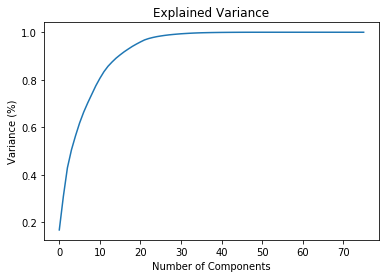

In [335]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(berlin_grouped_clustering)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

The PCA results in a large number of components to describe the variance of the uncerlying data. Although this is not ideal, a number of 10 components will be used to represent the data and reduce the dimensions. 

In [343]:
pca = PCA(n_components=10).fit(berlin_grouped_clustering)

### Number of clusters
Check whether a suitable number of clusters can be found for the dataset with the elbow method. For each *k* in a range from 2 to 30, the sum of squared distances between the datapoints within the clusters and the centroid value.

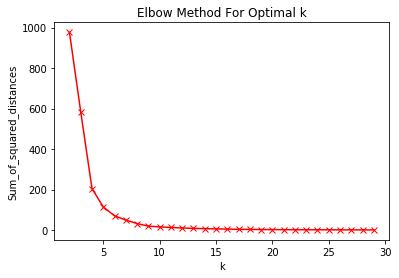

In [344]:
Sum_of_squared_distances = []
silhouettes = []
K = range(2,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(reduced_data)
    Sum_of_squared_distances.append(km.inertia_)
    
    labels = km.labels_
    silhouettes.append(metrics.silhouette_score(berlin_grouped_clustering_std,
                                                labels, metric='euclidean'))
    
#plt.plot(K, silhouettes, 'bx-')
plt.plot(K, Sum_of_squared_distances, 'rx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

A *k* value of 5 can be taken as the number of suitable clusters based on the position in the curve above.

In [28]:
# set number of clusters
kclusters = 5

berlin_grouped_clustering = berlin_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(reduced_data)

array([4, 0, 4, 0, 4, 1, 0, 4, 1, 4], dtype=int32)

The cluster labels are added to the neighborhood venues dataset.

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

berlin_merged = df

# merge neighborhoods_venues_sorted with berlin_merged to add latitude/longitude for each neighborhood
berlin_merged = berlin_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
# merge berlin top with berlin_merged to get number of venue counts per neighborhood
berlin_merged = berlin_merged.join(berlin_top.set_index('Neighborhood'), on='Neighborhood')

Sorting the neighborhoods by venue count again. The top-five areas are either in cluster 0 or cluster 4.

In [345]:
berlin_merged_sort = berlin_merged.sort_values(by=["Venue_Count"], ascending=False)
### Drop neighborhoods with NaN values i.e. no venues of selected types (e.g. Restaurants)
### are located there
berlin_merged_sort = berlin_merged_sort.dropna()
berlin_merged_sort.head()

,Neighborhood,Borough,Long,Lat,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue_Count
1,Moabit,Mitte,13.342542,52.530102,0.0,Doner Restaurant,German Restaurant,Italian Restaurant,Turkish Restaurant,Vietnamese Restaurant,Burger Joint,Vegetarian / Vegan Restaurant,Pizza Place,BBQ Joint,Restaurant,39.0
44,Schöneberg,Tempelhof-Schöneberg,13.355190,52.482157,4.0,Restaurant,Italian Restaurant,Doner Restaurant,German Restaurant,French Restaurant,Turkish Restaurant,Pizza Place,Indian Restaurant,Cuban Restaurant,Modern European Restaurant,38.0
8,Prenzlauer Berg,Pankow,13.428565,52.539847,0.0,Vietnamese Restaurant,Falafel Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Burger Joint,Asian Restaurant,Italian Restaurant,Chinese Restaurant,Korean Restaurant,Empanada Restaurant,38.0
21,Charlottenburg,Charlottenburg-Wilmersdorf,13.309683,52.515747,4.0,Italian Restaurant,Chinese Restaurant,Burger Joint,Sushi Restaurant,Asian Restaurant,Falafel Restaurant,German Restaurant,Pizza Place,Kebab Restaurant,Salad Place,37.0
6,Friedrichshain,Friedrichshain-Kreuzberg,13.450290,52.512215,0.0,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Pizza Place,Italian Restaurant,Thai Restaurant,Bagel Shop,Vietnamese Restaurant,Falafel Restaurant,German Restaurant,Korean Restaurant,37.0


Showing a map that represents the clustered neighborhoods. The markers represent the geolocation of the neighborhoods and the individual clusters are color-coded.

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_merged_sort['Lat'], 
                                  berlin_merged_sort['Long'], 
                                  berlin_merged_sort['Neighborhood'], 
                                  berlin_merged_sort['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.1).add_to(map_clusters)

# set markers for the top 10 neighborhoods
for neighborhood in berlin_top['Neighborhood'].head(5):
    # get coordinates for each neighborhood
    lng = df[df.Neighborhood == neighborhood].Long.values[0]
    lat = df[df.Neighborhood == neighborhood].Lat.values[0]
    
    # set markers for the neighborhoods
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker([lat, lng], radius=1, popup=label, color='blue', 
                        fill=True, fill_color='#3186cc', fill_opacity=1.7, parse_html=False).add_to(map_clusters)  
    
    # get the venues for each neighborhood
       
map_clusters

### Automated facility placement

The facilities could be placed manually by looking at the geolocation of the target venues and taking the mean latitude and longitude values to calculate a location. This was done in an automated way by utilizing the k-means algorithm. k-means calculates a centroid, based on the the mean value of the data points within the respective cluster. <br>
The geolocation of the venue from the neighborhoods of interest will be used as features to place the centroids, i.e. facilites on the map. A k of 10 clusters will be used initially, since 10 facilities can be placed in total. If some clusters are redundant i.e. the coverage over a region is already given by a smaller number of clusters, k will be reduced accordingly and covering additional neighborhoods will be considered.

## Results and discussion

### Neighborhoods clustering

The cluster 0 and 4 are explored to check if there is a category profile which will help to characterize the neghborhood and make decisions on the farmin setup. 

Exploring cluster 0

In [32]:
cluster = berlin_merged_sort[berlin_merged_sort["Cluster_Labels"]==0.0]
cluster = cluster[cluster.columns[cluster.columns.str.contains('Common')]]

The three most commonly occurring venue categories are considered. The counts of each category is combined from the 1st, 2nd and 3rd common venue column.

In [33]:
x1 = pd.get_dummies(cluster[['1st Most Common Venue']], prefix="", prefix_sep="").sum()
x2 = pd.get_dummies(cluster[['2nd Most Common Venue']], prefix="", prefix_sep="").sum()
x3 = pd.get_dummies(cluster[['3rd Most Common Venue']], prefix="", prefix_sep="").sum()

<BarContainer object of 30 artists>

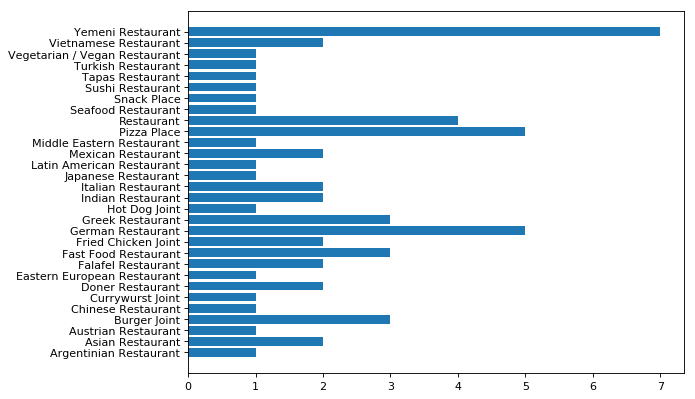

In [34]:
i = x3.combine(x1.combine(x2, max, fill_value=0),max, fill_value=0).index
x = x3.combine(x1.combine(x2, max, fill_value=0),max, fill_value=0).values
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.barh(i, x)

Exploring cluster 4

In [35]:
cluster = berlin_merged_sort[berlin_merged_sort["Cluster_Labels"]==4.0]
cluster = cluster[cluster.columns[cluster.columns.str.contains('Common')]]

In [36]:
x1 = pd.get_dummies(cluster[['1st Most Common Venue']], prefix="", prefix_sep="").sum()
x2 = pd.get_dummies(cluster[['2nd Most Common Venue']], prefix="", prefix_sep="").sum()
x3 = pd.get_dummies(cluster[['3rd Most Common Venue']], prefix="", prefix_sep="").sum()

<BarContainer object of 26 artists>

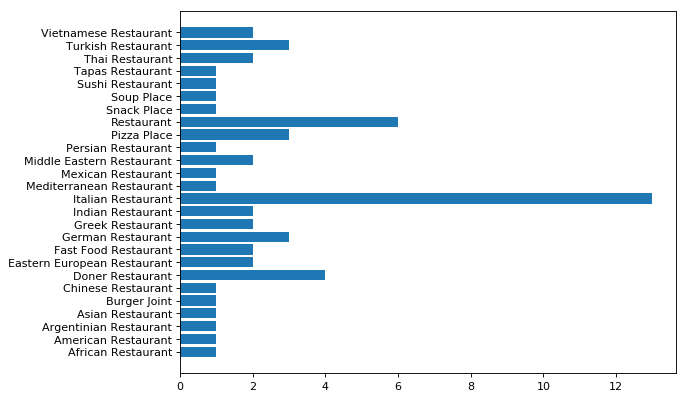

In [37]:
i = x3.combine(x1.combine(x2, max, fill_value=0),max, fill_value=0).index
x = x3.combine(x1.combine(x2, max, fill_value=0),max, fill_value=0).values
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.barh(i, x)

The above barplots show that the cluster 0 contains a lot of Yemeni and german restaurant
and pizza places. Cluster 4 is shows a relatively higher count of itialian restaurants.

### Neighborhoods of interest

From the analysis of the Foursqaure data, the most crowded neighborhoods, based on the count of target venues, could be extracted. The number of facilites the client is ready to invest allows for a total of 200 venues to consider for the current analysis. By squentially summing up the number of venues each of the most-crowded neighborhoods contains, a total of 5 neighborhoods should be considered for now with a total count of 189 venues. Including the next venue in the list would exceed the limit by ca. 30.

In [352]:
berlin_top.loc[:4].sum().values[1]

189

Therefore, the neighborhoods that are considered for the placement of the facilities are: *Moabit,Schöneberg, Prenzlauer Berg, Charlottenburg* and *Friedrichshain*.<br><br>
Each of these neighborhoods has almost twice twice the number of venues a single facility can supply. The count of venues is given in the table below.

In [347]:
berlin_top.head()

,Neighborhood,Venue_Count
0,Moabit,39
1,Schöneberg,38
2,Prenzlauer Berg,38
3,Charlottenburg,37
4,Friedrichshain,37


### Automated facility placement

The facility placement was automated with the k-means algorithm. The table below shows the count of venues within each cluster. The average number of venues per cluster is 19. There are clusters containing a number of venues which exceeds the supply limit of one facility. This will be considered individually and an additional facility might be added to cover the potential needs.

In [357]:
# Selected neighborhoods
selected = berlin_top["Neighborhood"].head(5).values
berlin_merged_sort[berlin_merged_sort['Neighborhood'].isin(selected)]

berlin_selected = berlin_data[berlin_data['Neighborhood'].isin(selected)]

venues_selected = berlin_selected[["Venue_Latitude", "Venue_Longitude"]]
# set number of clusters. We have 10 farms, so 10 centroids have to be placed on the map
kclusters = 10
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, tol=0.000001).fit(venues_selected)

berlin_selected.insert(0, 'Labels', kmeans.labels_)
berlin_selected.groupby("Labels").count()["Venue"]

Labels
0    30
1    31
2    26
3    23
4    22
5    17
6     6
7     8
8    12
9    14
Name: Venue, dtype: int64

Since the potential neighborhoods were determined, the automated placement of facilities with the k-means algorithm was performed. The map below shows the placement of facilities with a green circle of 1 km radius, indicating the coverage of each farm. The markers indicate the position of the venues from cluster 0 and cluster 4 colored red and blue, respectively. This suggests that a facility with an emphasis on italian cuisine could be planed in Schöneberg and Charlottenburg.

In [278]:
cluster_locations = kmeans.cluster_centers_
# create map of New York using latitude and longitude values
map_farms = folium.Map(location=[latitude, longitude], zoom_start=11, control_scale = True)

# add markers to map
for neighborhood in selected:
    
    l = berlin_merged_sort[berlin_merged_sort["Neighborhood"]==neighborhood]["Cluster_Labels"].values[0]
    if l == 0.0:
        cluster_color = "red"
    elif l == 4.0:
        cluster_color = "blue"
    else:
        cluster_color = "orange"
        
    # get the venues for each neighborhood
    df_temp = berlin_data[(berlin_data.Neighborhood == neighborhood)]# & (berlin_data.Venue_Category != "Supermarket")]
    
    for venue in df_temp.iterrows():
        venue_lat = venue[1].Venue_Latitude
        venue_long = venue[1].Venue_Longitude
        venue_cat = venue[1].Venue_Category
        
        # set markers for venues
#         if neighborhood == "Steglitz":
#             cluster_color = "orange"
#         else:
#             cluster_color = "blue"
        label = folium.Popup(venue_cat, parse_html=True)
        folium.CircleMarker([venue_lat, venue_long], radius=5, popup=label, color=cluster_color, 
                            fill=True, fill_color='#3186cc', fill_opacity=0.7, parse_html=False).add_to(map_farms)  

for i,c in enumerate(cluster_locations):
    folium.Circle([c[0], c[1]], color='green', popup=str(i),
                    radius=1000).add_to(map_farms)
map_farms

The k-means algorithm resulted in two facilities placed for each neighborhood. The demand of venues is therefore met.

### Adjusting the coordinates of the farms to capture outlier venues.

The initial facility placement from k-means yielded two veneus not encompassed the closest
facility circle. The assumed radius of supply is one kilometer. So either this radius can be extended accordingly or the facility location can be manually adjusted. This was done as an example with the facility 2 and 9 (numeration based on cluster label). The initial locations of these were:<br><br>
Old location of facility 2 [52.48267996 13.34877479] <br>
Old location of facility 9 [52.53584382 13.43064389] <br><br>

The facilities can be moved according to the positions below, to reach the outlier venues.

In [273]:
cluster_locations[2] = np.array([52.48267996, 13.356])
cluster_locations[9] = np.array([52.54, 13.43064389])

The final locations for the farming facilities in the most promising neighborhoods in Berlin are:

In [280]:
cluster_locations

array([[52.51080074, 13.45791386],
       [52.51323795, 13.31446271],
       [52.48267996, 13.356     ],
       [52.53964775, 13.42099882],
       [52.5280557 , 13.33806569],
       [52.51224911, 13.3050439 ],
       [52.48657081, 13.35749502],
       [52.51238908, 13.45093717],
       [52.52854372, 13.34864833],
       [52.54      , 13.43064389]])

## Conclusion

The aim of this project was to identify neighborhoods that will provide enough customers for an urban farming business. The farming facilities would be placed strategically around the city to cover the areas of interest and provide fresh vegetables and herbs to food serving venues. The machine learning and data analysis approaches in this project resulted in a list of suggested neighborhoods in Berlin with potential venues that could be further targeted and acquired as customers by a marketing campaign. Additionally, a placement of the farming facilities was suggested in order to meet the demands of the future customers. All in all, an initial consultation and suggestion was given with this project, that could serve as a foundation for further analysis and business development. 